In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print("Here")
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Here
/kaggle/input/jena-climate/jena_climate_2009_2016.csv


In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)

In [13]:
# Function to load and preprocess the data, including date extraction
def load_and_preprocess_data_with_dates(file_path, sequence_length=60):
    # Load data and separate Date column
    data = pd.read_csv(file_path)
    dates = data['Date Time'].values  # Extract Date column
    data = data.iloc[:105000, 1:]  # Drop the Date column for scaling
    
    # Convert non-numeric columns and scale features
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.dropna()
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Create sequences
    X, y, sequence_dates = [], [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        y.append(data_scaled[i])
        sequence_dates.append(dates[i])  # Track dates for each sequence end

    return np.array(X), np.array(y), sequence_dates, scaler

# Load and preprocess the data
file_path = '/kaggle/input/jena-climate/jena_climate_2009_2016.csv'  # Adjust path as needed
sequence_length = 60
X_jena, y_jena, sequence_dates, scaler_jena = load_and_preprocess_data_with_dates(file_path, sequence_length)


In [14]:
# Define LSTM model
def create_model(input_shape, output_dim):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(output_dim))  # Ensure output shape matches y dimension
    return model

input_shape = (X_jena.shape[1], X_jena.shape[2])
output_dim = y_jena.shape[1]
model = create_model(input_shape, output_dim)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Train and plot results with custom loss function
def train_and_evaluate_with_plot(model, X, y, loss_function, loss_name, sequence_dates, scaler, epochs=50, batch_size=32):
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae'])
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    print(f"The accuracy using {loss_name} - MAE: {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot training loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'{loss_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

        # Rescale predicted and true values
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_true_rescaled = scaler.inverse_transform(y)
    
    # Select only the first 5000 values
    sequence_dates_5000 = sequence_dates[:5000]
    y_pred_rescaled_5000 = y_pred_rescaled[:5000, -1]
    y_true_rescaled_5000 = y_true_rescaled[:5000, -1]
    
    # Plot Predicted vs True AQI for the first 5000 values
    plt.figure(figsize=(14, 7))
    plt.plot(sequence_dates_5000, y_true_rescaled_5000, label='True Climate', color='blue')
    plt.plot(sequence_dates_5000, y_pred_rescaled_5000, label='Predicted Climate', color='red', linestyle='dashed')
    plt.title(f'True vs Predicted AQI (First 5000 Values) with {loss_name}')
    plt.xlabel('Date')
    plt.ylabel('Climate')
    plt.legend()
    plt.show()
            
    return [mae,mse,rmse,r2]

Training with Huber Loss...
Epoch 1/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 0.0037 - mae: 0.0386
Epoch 2/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0010 - mae: 0.0167
Epoch 3/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 9.8752e-04 - mae: 0.0151
Epoch 4/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 9.6735e-04 - mae: 0.0144
Epoch 5/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 9.5603e-04 - mae: 0.0140
Epoch 6/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 9.4779e-04 - mae: 0.0138
Epoch 7/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 9.3979e-04 - mae: 0.0136
Epoch 8/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 9.3021e-04 - mae: 0.0135
Epoch 9/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 9.1811e-04 - mae: 0.0133
Epoch 10/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 9.0943e-04 - mae: 0.0132
Epoch 11/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 9.0357e-04 - mae: 0.0130
Epoch 12/5

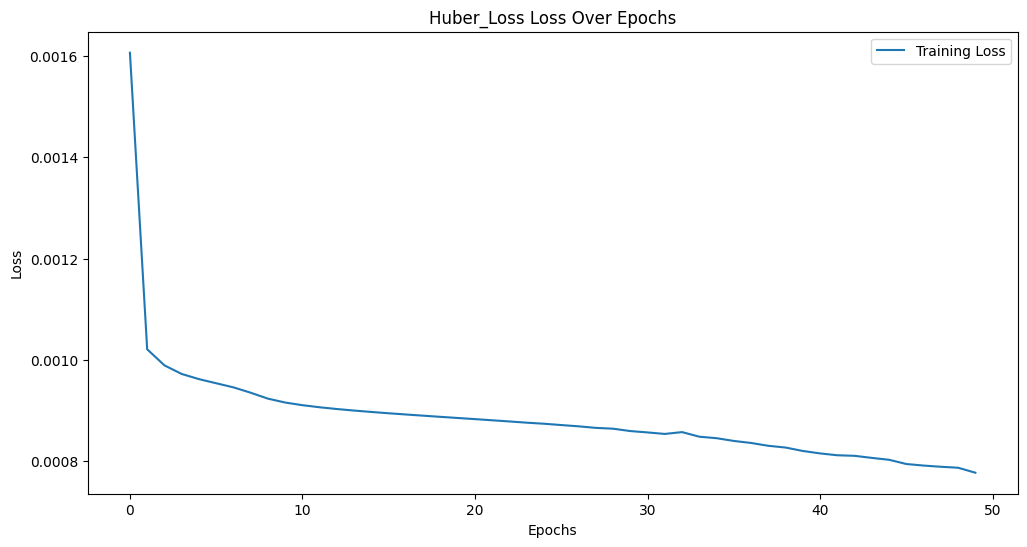

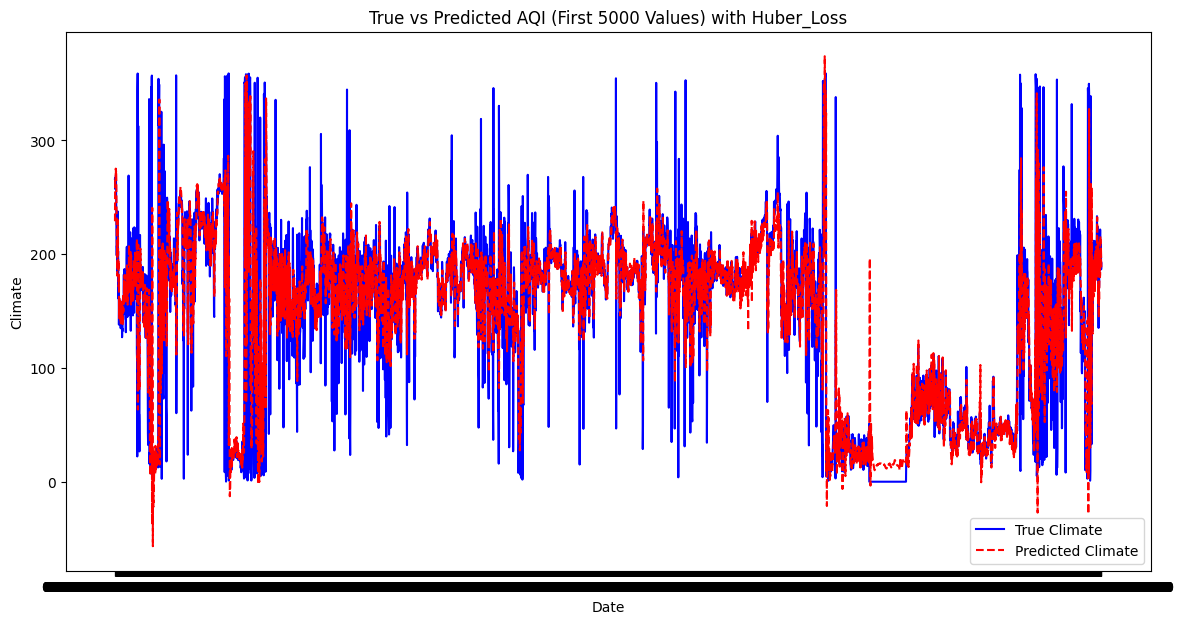

TypeError: Huber.get_config() missing 1 required positional argument: 'self'

In [17]:
# Train and plot with MSE loss
print("Training with Huber Loss...")
[mae_huber,mse_huber,rmse_huber,r2_huber] = train_and_evaluate_with_plot(model, X_jena, y_jena, tf.keras.losses.Huber, "Huber_Loss", sequence_dates, scaler_jena, epochs=50)
model.save("model_huber_loss.h5")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with Mean Absolute Error Loss...
Epoch 1/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0353 - mae: 0.0353
Epoch 2/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0139 - mae: 0.0139
Epoch 3/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0129 - mae: 0.0129
Epoch 4/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0125 - mae: 0.0125
Epoch 5/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0123 - mae: 0.0123
Epoch 6/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0122 - mae: 0.0122
Epoch 7/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0121 - mae: 0.0121
Epoch 8/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0120 - mae: 0.0120
Epoch 9/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0120 - mae: 0.0120
Epoch 10/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0119 - mae: 0.0119
Epoch 11/50
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0119 - mae: 0.0119
Epoch 12/50
3280/3280 ━━━━━━━━━━

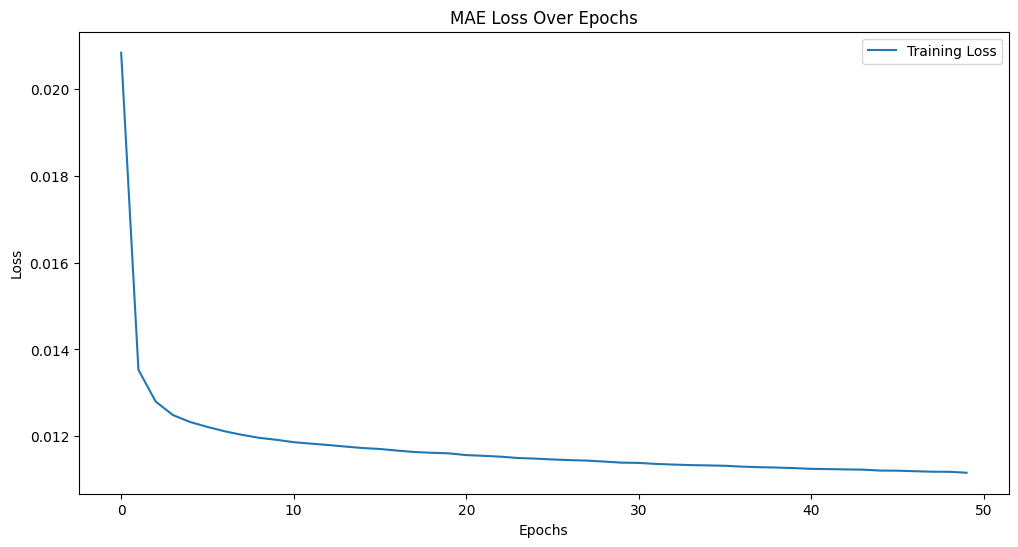

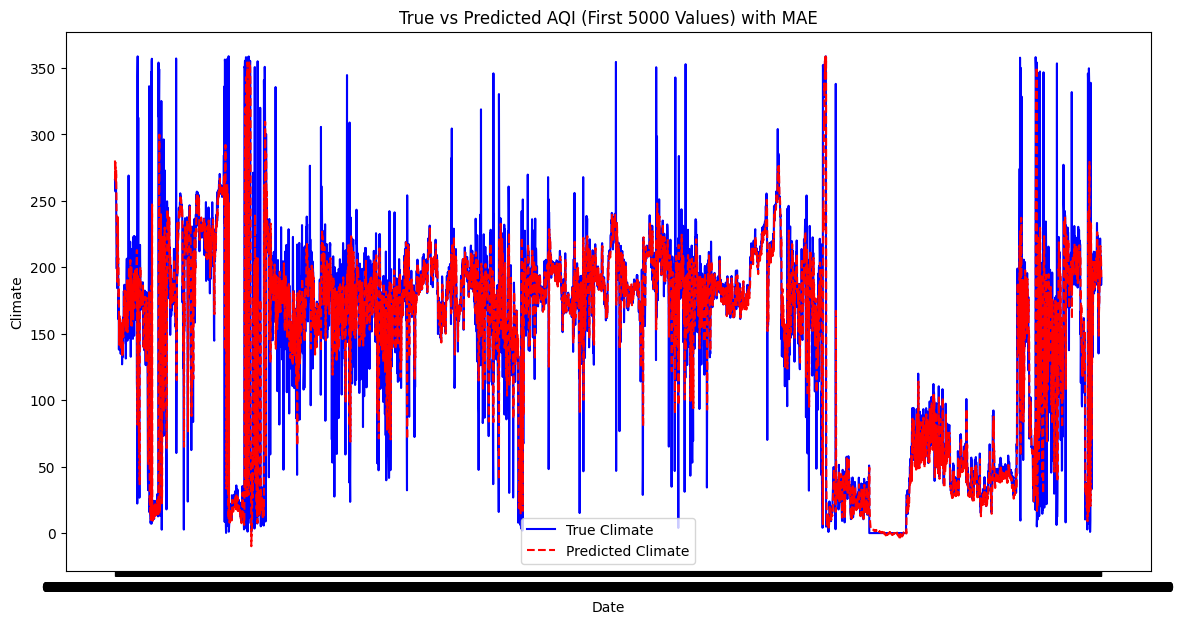

In [19]:
model = create_model(input_shape, output_dim)

# Train and plot with MAE loss
print("Training with Mean Absolute Error Loss...")
[mae_mae,mse_mae,rmse_mae,r2_mae] = train_and_evaluate_with_plot(model, X_jena, y_jena, 'mae', "MAE", sequence_dates, scaler_jena, epochs=50)
model.save("model_mae_loss.h5")


In [22]:
# Compare Results

print("\nComparison of MAE for Loss Functions:")
print(f"The accuracy using MAE Loss - MAE: {mae_mae:.4f}")
print(f"The accuracy using Huber Loss - MAE: {mae_huber:.4f}")

print("\nComparison of MSE for Loss Functions:")
print(f"The accuracy using MAE Loss - MSE: {mse_mae:.4f}")
print(f"The accuracy using Huber Loss - MSE: {mse_huber:.4f}")

print("\nComparison of RMSE for Loss Functions:")
print(f"The accuracy using MAE Loss - RMSE: {rmse_mae:.4f}")
print(f"The accuracy using Huber Loss - RMSE: {rmse_huber:.4f}")

print("\nComparison of R2 for Loss Functions:")
print(f"The accuracy using MAE Loss - R2: {r2_mae:.4f}")
print(f"The accuracy using Huber Loss - R2: {r2_huber:.4f}")




Comparison of MAE for Loss Functions:
The accuracy using MAE Loss - MAE: 0.0110
The accuracy using Huber Loss - MAE: 0.0140

Comparison of MSE for Loss Functions:
The accuracy using MAE Loss - MSE: 0.0019
The accuracy using Huber Loss - MSE: 0.0019

Comparison of RMSE for Loss Functions:
The accuracy using MAE Loss - RMSE: 0.0441
The accuracy using Huber Loss - RMSE: 0.0436

Comparison of R2 for Loss Functions:
The accuracy using MAE Loss - R2: 0.9529
The accuracy using Huber Loss - R2: 0.9526
